In [187]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from skimage.exposure import rescale_intensity
import numpy as np
from rasterio.enums import Resampling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd

In [3]:
# Data location
sample_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Sample_GEDI_v1.geojson"
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

In [4]:
# Load sample
sample = gpd.read_file(sample_dir)

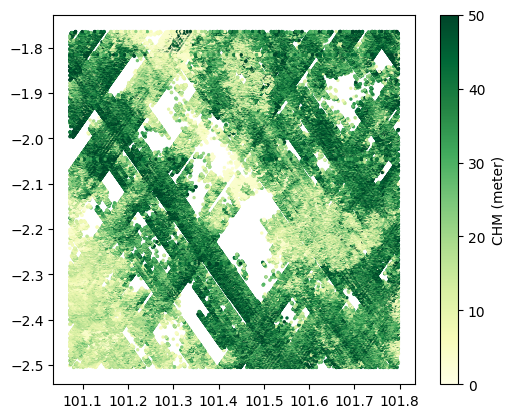

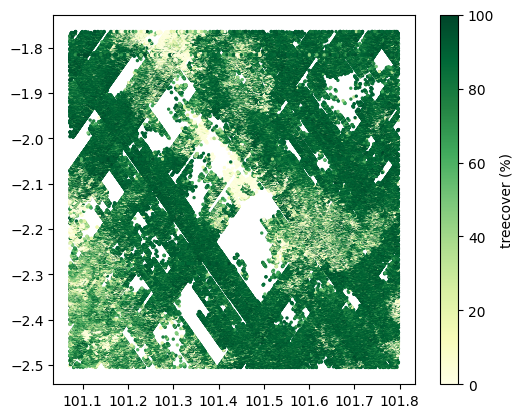

In [15]:
# GEDI Data parameter
gedi_props = [
    { "name": "CHM", "unit": "meter", "min": 0, "max": 50 },
    { "name": "treecover", "unit": "%", "min": 0, "max": 100 }
]

# Visualize sample
for dict in gedi_props:
    name = dict['name']
    unit = dict['unit']
    min = dict['min']
    max = dict['max']

    sample.plot(column=name, cmap='YlGn', markersize=2, legend=True, vmin=min, vmax=max, legend_kwds={"label": f'{name} ({unit})'})

sample_extract = sample.copy()
coords = [
    (x, y) for x, y in zip(sample_extract["geometry"].x, sample_extract["geometry"].y)
]

In [6]:
# Load landsat data
landsat = rio.open(landsat_dir)
landsat_image = landsat.read() / 1e4

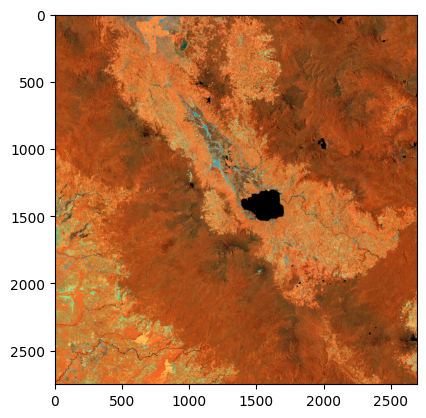

In [ ]:
# False color composite
out_range = (0, 1)
red = rescale_intensity(landsat_image[4], in_range=(0.1, 0.4), out_range=out_range)
green = rescale_intensity(landsat_image[5], in_range=(0.05, 0.3), out_range=out_range)
blue = rescale_intensity(landsat_image[6], in_range=(0.025, 0.25), out_range=out_range)
arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

# Plot landsat image
plt.imshow(composite)

In [79]:
# Extract sample
sample_extract[["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9"]] = np.stack([x for x in landsat.sample(coords)]) / 1e4
sample_extract

,id,CHM,treecover,geometry,B1,B2,B3,B4,B5,B6,B7,B9,HH,HV
0,0,21.570000,79.583597,POINT (101.78126 -1.81583),0.0140,0.0176,0.0372,0.0222,0.3318,0.1375,0.0521,0.0028,-6.052,-10.132
1,1,36.820000,83.417898,POINT (101.79114 -1.81583),0.0155,0.0192,0.0348,0.0197,0.2832,0.1185,0.0417,0.0015,-8.490,-12.415
2,2,43.369999,90.923297,POINT (101.77452 -1.81561),0.0143,0.0172,0.0392,0.0207,0.3020,0.1274,0.0505,0.0034,-7.083,-11.438
3,3,57.869999,91.172498,POINT (101.78081 -1.81538),0.0139,0.0171,0.0338,0.0211,0.2879,0.1162,0.0460,0.0038,-8.710,-12.762
4,4,34.380001,86.333001,POINT (101.79069 -1.81538),0.0158,0.0183,0.0381,0.0198,0.3261,0.1350,0.0467,0.0012,-7.890,-12.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220483,220483,64.320000,94.916499,POINT (101.3961 -2.27599),0.0134,0.0184,0.0346,0.0248,0.2261,0.1249,0.0564,0.0015,-8.730,-12.553
220484,220484,42.580000,90.350550,POINT (101.40621 -2.27599),0.0182,0.0211,0.0366,0.0238,0.2727,0.1324,0.0554,0.0014,-6.276,-10.800
220485,220485,35.000000,89.628202,POINT (101.4125 -2.27599),0.0129,0.0169,0.0334,0.0251,0.2086,0.1137,0.0507,0.0027,-6.469,-10.499
220486,220486,38.080002,82.567102,POINT (101.41609 -2.27599),0.0161,0.0188,0.0389,0.0246,0.2664,0.1226,0.0539,0.0041,-7.323,-12.116


C:\Users\ramiq\AppData\Local\Temp\ipykernel_19116\1684620434.py:10: RuntimeWarning: divide by zero encountered in divide
  ndmi = (nir - swir1) / (nir + swir1)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_19116\1684620434.py:15: RuntimeWarning: divide by zero encountered in divide
  nbr = (nir - swir2) / (nir + swir2)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_19116\1684620434.py:20: RuntimeWarning: divide by zero encountered in divide
  nbr2 = (swir1 - swir2) / (swir1 + swir2)


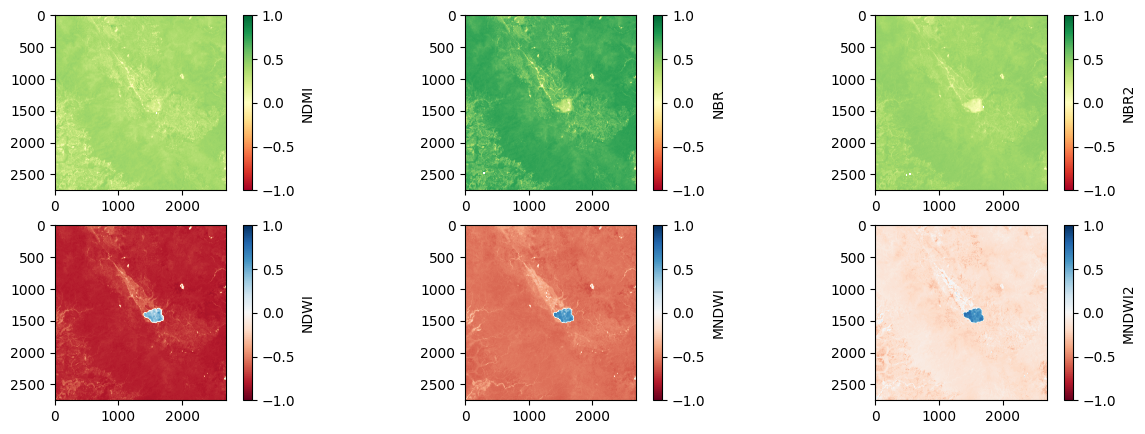

In [201]:
# Define image band
green = landsat_image[2]
nir = landsat_image[4]
swir1 = landsat_image[5]
swir2 = landsat_image[6]

plt.figure(figsize=(15, 5))

# Generate other indices
ndmi = (nir - swir1) / (nir + swir1)
plt.subplot(2, 3, 1)
plt.imshow(ndmi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDMI')

nbr = (nir - swir2) / (nir + swir2)
plt.subplot(2, 3, 2)
plt.imshow(nbr, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NBR')

nbr2 = (swir1 - swir2) / (swir1 + swir2)
plt.subplot(2, 3, 3)
plt.imshow(nbr2, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NBR2')

ndwi = (green - nir) / (green + nir)
plt.subplot(2, 3, 4)
plt.imshow(ndwi, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='NDWI')

mndwi = (green - swir1) / (green + swir1)
plt.subplot(2, 3, 5)
plt.imshow(mndwi, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='MNDWI')

mndwi2 = (green - swir2) / (green + swir2)
plt.subplot(2, 3, 6)
plt.imshow(mndwi2, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='MNDWI2')

In [13]:
# Load palsar image
palsar = rio.open(palsar_dir)
palsar_image = palsar.read(
    out_shape=(palsar.count, landsat_image.shape[1], landsat_image.shape[2]),
    resampling=Resampling.bilinear,
) / 1e3

,id,CHM,treecover,geometry,B1,B2,B3,B4,B5,B6,B7,B9,HH,HV
0,0,21.570000,79.583597,POINT (101.78126 -1.81583),0.0140,0.0176,0.0372,0.0222,0.3318,0.1375,0.0521,0.0028,-6.052,-10.132
1,1,36.820000,83.417898,POINT (101.79114 -1.81583),0.0155,0.0192,0.0348,0.0197,0.2832,0.1185,0.0417,0.0015,-8.490,-12.415
2,2,43.369999,90.923297,POINT (101.77452 -1.81561),0.0143,0.0172,0.0392,0.0207,0.3020,0.1274,0.0505,0.0034,-7.083,-11.438
3,3,57.869999,91.172498,POINT (101.78081 -1.81538),0.0139,0.0171,0.0338,0.0211,0.2879,0.1162,0.0460,0.0038,-8.710,-12.762
4,4,34.380001,86.333001,POINT (101.79069 -1.81538),0.0158,0.0183,0.0381,0.0198,0.3261,0.1350,0.0467,0.0012,-7.890,-12.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220483,220483,64.320000,94.916499,POINT (101.3961 -2.27599),0.0134,0.0184,0.0346,0.0248,0.2261,0.1249,0.0564,0.0015,-8.730,-12.553
220484,220484,42.580000,90.350550,POINT (101.40621 -2.27599),0.0182,0.0211,0.0366,0.0238,0.2727,0.1324,0.0554,0.0014,-6.276,-10.800
220485,220485,35.000000,89.628202,POINT (101.4125 -2.27599),0.0129,0.0169,0.0334,0.0251,0.2086,0.1137,0.0507,0.0027,-6.469,-10.499
220486,220486,38.080002,82.567102,POINT (101.41609 -2.27599),0.0161,0.0188,0.0389,0.0246,0.2664,0.1226,0.0539,0.0041,-7.323,-12.116


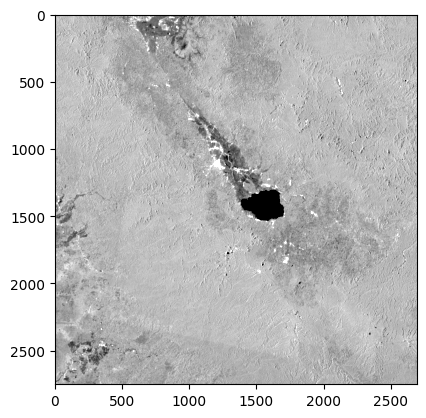

In [ ]:
# Plot palsar image
plt.imshow(palsar_image[0], cmap="gray", vmin=-15, vmax=-5)

In [194]:
# Extract sample palsar
sample_extract[["HH", "HV"]] = np.stack([x for x in palsar.sample(coords)]) / 1e3
sample_extract

,id,CHM,treecover,geometry,B1,B2,B3,B4,B5,B6,...,HH,HV,NDMI,NBR,NBR2,NDWI,MNDWI,MNDWI2,RVI,RVI2
0,0,21.570000,79.583597,POINT (101.78126 -1.81583),0.0140,0.0176,0.0372,0.0222,0.3318,0.1375,...,-6.052,-10.132,0.414021,0.728575,0.450422,-0.798374,-0.574127,-0.166853,0.595508,1.492961
1,1,36.820000,83.417898,POINT (101.79114 -1.81583),0.0155,0.0192,0.0348,0.0197,0.2832,0.1185,...,-8.490,-12.415,0.410007,0.743306,0.479401,-0.781132,-0.545988,-0.090196,0.678789,1.617330
2,2,43.369999,90.923297,POINT (101.77452 -1.81561),0.0143,0.0172,0.0392,0.0207,0.3020,0.1274,...,-7.083,-11.438,0.406614,0.713475,0.432265,-0.770223,-0.529412,-0.125975,0.635778,1.554680
3,3,57.869999,91.172498,POINT (101.78081 -1.81538),0.0139,0.0171,0.0338,0.0211,0.2879,0.1162,...,-8.710,-12.762,0.424895,0.724468,0.432799,-0.789866,-0.549333,-0.152882,0.669030,1.603398
4,4,34.380001,86.333001,POINT (101.79069 -1.81538),0.0158,0.0183,0.0381,0.0198,0.3261,0.1350,...,-7.890,-12.063,0.414444,0.749463,0.485966,-0.790774,-0.559792,-0.101415,0.654391,1.582191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220483,220483,64.320000,94.916499,POINT (101.3961 -2.27599),0.0134,0.0184,0.0346,0.0248,0.2261,0.1249,...,-8.730,-12.553,0.288319,0.600708,0.377827,-0.734561,-0.566144,-0.239560,0.686335,1.627992
220484,220484,42.580000,90.350550,POINT (101.40621 -2.27599),0.0182,0.0211,0.0366,0.0238,0.2727,0.1324,...,-6.276,-10.800,0.346334,0.662298,0.410011,-0.763337,-0.566864,-0.204348,0.579220,1.467103
220485,220485,35.000000,89.628202,POINT (101.4125 -2.27599),0.0129,0.0169,0.0334,0.0251,0.2086,0.1137,...,-6.469,-10.499,0.294446,0.608947,0.383212,-0.723967,-0.545887,-0.205707,0.617911,1.527677
220486,220486,38.080002,82.567102,POINT (101.41609 -2.27599),0.0161,0.0188,0.0389,0.0246,0.2664,0.1226,...,-7.323,-12.116,0.369666,0.663441,0.389235,-0.745169,-0.518266,-0.161638,0.629340,1.545018


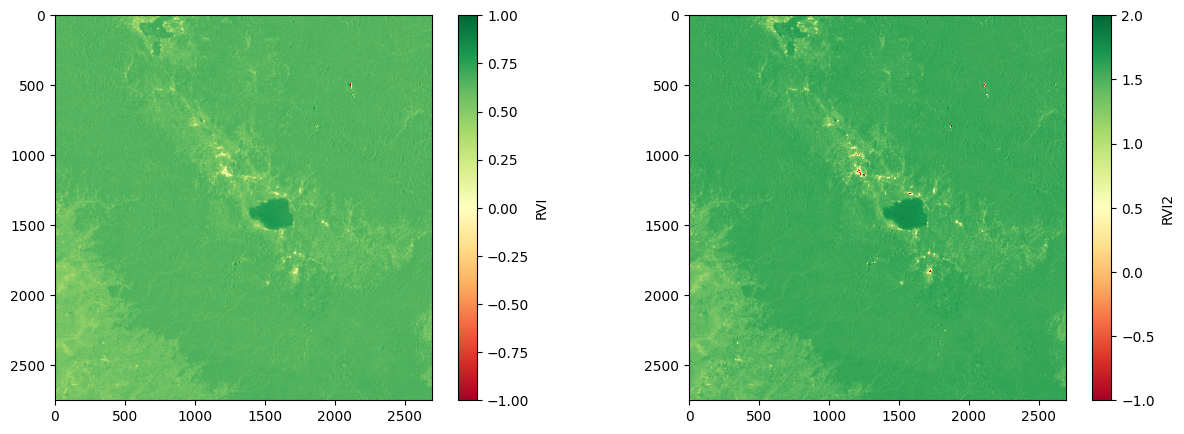

In [205]:
# Palsar indices
hh = palsar_image[0]
hv = palsar_image[1]

plt.figure(figsize=(15, 5))

rvi = hh / hv
plt.subplot(1, 2, 1)
plt.imshow(rvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='RVI')

rvi2 = 4 * hh / (hh + hv)
plt.subplot(1, 2, 2)
plt.imshow(rvi2, cmap='RdYlGn', vmin=-1, vmax=2)
plt.colorbar(label='RVI2')

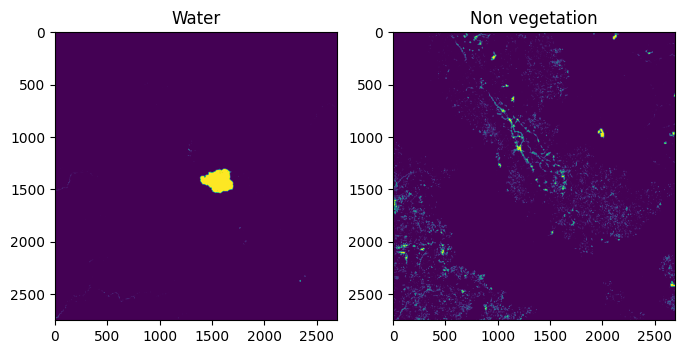

In [229]:
# Create mask image
plt.figure(figsize=(8, 4))

water_image = ndwi > 0
plt.subplot(1, 2, 1)
plt.title('Water')
plt.imshow(water_image)

non_vegetation = ndmi < 0.1
plt.subplot(1, 2, 2)
plt.title('Non vegetation')
plt.imshow(non_vegetation)

In [206]:
# Save the indices as geotiff
indices = np.clip(np.stack([ndmi, nbr, nbr2, ndwi, mndwi, mndwi2, rvi, rvi2]).astype('float'), -2, 2)

# Save image to geotiff
output = rio.open(
    "data/indices.tif",
    "w",
    "COG",
    count=indices.shape[0],
    width=indices.shape[2],
    height=indices.shape[1],
    crs=landsat.crs,
    transform=landsat.transform,
    dtype="float32",
    nodata=-9999,
    compress="lzw",
    resampling="bilinear",
    tiled=True,
)
output.write(indices)
output.close()

In [207]:
# Sample indices
indices_source = rio.open('data/indices.tif')
sample_extract[["NDMI", "NBR", "NBR2", "NDWI", "MNDWI", "MNDWI2", "RVI", "RVI2"]] = np.stack([x for x in indices_source.sample(coords)])
indices_source.close()
sample_extract

,id,CHM,treecover,geometry,B1,B2,B3,B4,B5,B6,...,HH,HV,NDMI,NBR,NBR2,NDWI,MNDWI,MNDWI2,RVI,RVI2
0,0,21.570000,79.583597,POINT (101.78126 -1.81583),0.0140,0.0176,0.0372,0.0222,0.3318,0.1375,...,-6.052,-10.132,0.414021,0.728575,0.450422,-0.798374,-0.574127,-0.166853,0.595508,1.492961
1,1,36.820000,83.417898,POINT (101.79114 -1.81583),0.0155,0.0192,0.0348,0.0197,0.2832,0.1185,...,-8.490,-12.415,0.410007,0.743306,0.479401,-0.781132,-0.545988,-0.090196,0.678789,1.617330
2,2,43.369999,90.923297,POINT (101.77452 -1.81561),0.0143,0.0172,0.0392,0.0207,0.3020,0.1274,...,-7.083,-11.438,0.406614,0.713475,0.432265,-0.770223,-0.529412,-0.125975,0.635778,1.554680
3,3,57.869999,91.172498,POINT (101.78081 -1.81538),0.0139,0.0171,0.0338,0.0211,0.2879,0.1162,...,-8.710,-12.762,0.424895,0.724468,0.432799,-0.789866,-0.549333,-0.152882,0.669030,1.603398
4,4,34.380001,86.333001,POINT (101.79069 -1.81538),0.0158,0.0183,0.0381,0.0198,0.3261,0.1350,...,-7.890,-12.063,0.414444,0.749463,0.485966,-0.790774,-0.559792,-0.101415,0.654391,1.582191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220483,220483,64.320000,94.916499,POINT (101.3961 -2.27599),0.0134,0.0184,0.0346,0.0248,0.2261,0.1249,...,-8.730,-12.553,0.288319,0.600708,0.377827,-0.734561,-0.566144,-0.239560,0.686335,1.627992
220484,220484,42.580000,90.350550,POINT (101.40621 -2.27599),0.0182,0.0211,0.0366,0.0238,0.2727,0.1324,...,-6.276,-10.800,0.346334,0.662298,0.410011,-0.763337,-0.566864,-0.204348,0.579220,1.467103
220485,220485,35.000000,89.628202,POINT (101.4125 -2.27599),0.0129,0.0169,0.0334,0.0251,0.2086,0.1137,...,-6.469,-10.499,0.294446,0.608947,0.383212,-0.723967,-0.545887,-0.205707,0.617911,1.527677
220486,220486,38.080002,82.567102,POINT (101.41609 -2.27599),0.0161,0.0188,0.0389,0.0246,0.2664,0.1226,...,-7.323,-12.116,0.369666,0.663441,0.389235,-0.745169,-0.518266,-0.161638,0.629340,1.545018


In [233]:
# Outlier tolerance
outlier_multiplier = 4

# Sample filter by outlier
sample_normal = sample_extract.copy()

# Filter sample based on std deviation
for dict in gedi_props:
    name = dict['name']
    sample_normal = sample_normal[sample_normal[name] > 0]
    mean = np.mean(sample_normal[name])
    stddev = np.std(sample_normal[name])
    sample_normal = sample_normal[sample_normal[name] > ((mean - (stddev * outlier_multiplier)))]
    sample_normal = sample_normal[sample_normal[name] < ((mean + (stddev * outlier_multiplier)))]

In [234]:
# Limit sample size
seeds = 4
sample_limit = sample_normal.sample(frac=0.1, random_state=seeds)
sample_limit

,id,CHM,treecover,geometry,B1,B2,B3,B4,B5,B6,...,HH,HV,NDMI,NBR,NBR2,NDWI,MNDWI,MNDWI2,RVI,RVI2
20766,20766,3.700000,2.754700,POINT (101.27079 -1.78529),0.0182,0.0227,0.0653,0.0339,0.3957,0.1711,...,-11.228,-15.854,0.396260,0.707812,0.432998,-0.716703,-0.447547,-0.018045,0.701185,1.648697
78057,78057,30.920000,89.070201,POINT (101.38128 -2.21603),0.0122,0.0171,0.0372,0.0245,0.2781,0.1178,...,-7.346,-10.979,0.404900,0.696249,0.405728,-0.764034,-0.520000,-0.144828,0.632300,1.549470
95128,95128,15.440000,54.392058,POINT (101.13559 -2.38739),0.0201,0.0226,0.0428,0.0304,0.3092,0.1671,...,-8.446,-14.997,0.298341,0.636845,0.417904,-0.756818,-0.592187,-0.231598,0.561352,1.438118
209823,209823,40.360001,91.572398,POINT (101.47313 -2.42961),0.0121,0.0156,0.0398,0.0242,0.3101,0.1322,...,-7.588,-12.080,0.402216,0.724215,0.454345,-0.772506,-0.537209,-0.109620,0.647929,1.572711
217575,217575,28.420000,76.715600,POINT (101.41609 -2.31485),0.0129,0.0165,0.0365,0.0237,0.2978,0.1252,...,-7.291,-11.972,0.408038,0.716921,0.436604,-0.781633,-0.548547,-0.147196,0.609228,1.514336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100080,100080,32.410000,87.874103,POINT (101.2663 -2.34472),0.0165,0.0191,0.0390,0.0202,0.2901,0.1252,...,-7.927,-12.133,0.397062,0.730391,0.469484,-0.762990,-0.524970,-0.073634,0.656142,1.584748
210278,210278,55.619999,90.890902,POINT (101.5313 -2.42399),0.0177,0.0213,0.0374,0.0254,0.2874,0.1278,...,-8.477,-12.033,0.384393,0.677269,0.395958,-0.769704,-0.547216,-0.193096,0.680890,1.620308
191115,191115,35.480000,82.879502,POINT (101.71456 -2.14372),0.0118,0.0143,0.0342,0.0188,0.3157,0.1202,...,-7.674,-11.444,0.448497,0.765660,0.483035,-0.804516,-0.556995,-0.101183,0.658443,1.588099
144399,144399,40.370001,90.146148,POINT (101.53242 -2.50551),0.0176,0.0188,0.0367,0.0214,0.2991,0.1241,...,-7.456,-11.912,0.413516,0.735422,0.462581,-0.781417,-0.543532,-0.108141,0.654943,1.582998


In [236]:
# Split sample to train and test
train, test = train_test_split(sample_limit, train_size=0.7, random_state=seeds)
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 15426
Test size: 6612


In [237]:
# Make random forest model
predictors = [
    "B1", "B2", "B3", 'B4', 'B5', 'B6', 'B7', "B9",
    "HH", "HV",
    "NDMI", "NBR", "NBR2",
    "NDWI", "MNDWI", "MNDWI2",
    "RVI"
]

# Make for model for each of the GEDI data type
for x in range(0, len(gedi_props)):
    dict = gedi_props[x]
    label = dict['name']

    corrs = []
    for band in predictors:
        r2 = np.corrcoef(sample_extract[label], sample_extract[band])[0][1] ** 2
        corrs.append({ "band": band, "r2": r2 })

    corrs.sort(key=lambda x: x['r2'], reverse=True)
    best = list(map(lambda x: x['band'], corrs[0:3]))

    model = RandomForestRegressor(100)
    model.fit(
        train[best],
        train[label]
    )

    gedi_props[x]['model'] = model
    gedi_props[x]['predictors'] = best

In [212]:
# Prepare image
combine_image = np.concatenate((landsat_image, palsar_image, indices), 0)
image_transpose = combine_image.T
transpose_shape = image_transpose.shape
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9", "HH", "HV", "NDMI", "NBR", "NBR2", "NDWI", "MNDWI", "MNDWI2", "RVI", "RVI2"],
)
table_image

,B1,B2,B3,B4,B5,B6,B7,B9,HH,HV,NDMI,NBR,NBR2,NDWI,MNDWI,MNDWI2,RVI,RVI2
0,0.0151,0.0165,0.0329,0.0213,0.2570,0.1103,0.0428,0.0023,-7.973,-12.063,0.399401,0.714476,0.440888,-0.773025,-0.540503,-0.130779,0.660947,1.591735
1,0.0166,0.0184,0.0335,0.0215,0.2700,0.1119,0.0458,0.0025,-8.477,-12.280,0.413983,0.709943,0.419150,-0.779242,-0.539202,-0.155107,0.690309,1.633569
2,0.0188,0.0198,0.0384,0.0216,0.3084,0.1288,0.0518,0.0026,-8.904,-12.676,0.410796,0.712382,0.426357,-0.778547,-0.540670,-0.148559,0.702430,1.650417
3,0.0204,0.0221,0.0420,0.0241,0.3381,0.1348,0.0528,0.0025,-8.938,-13.058,0.429901,0.729854,0.437100,-0.779006,-0.524887,-0.113924,0.684485,1.625386
4,0.0210,0.0231,0.0476,0.0274,0.3625,0.1518,0.0588,0.0024,-8.600,-13.174,0.409683,0.720864,0.441595,-0.767861,-0.522568,-0.105263,0.652801,1.579866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405687,0.0098,0.0139,0.0331,0.0209,0.2861,0.1183,0.0460,0.0026,-7.839,-11.874,0.414936,0.722975,0.440049,-0.792607,-0.562748,-0.163085,0.660182,1.590625
7405688,0.0091,0.0137,0.0331,0.0202,0.2860,0.1191,0.0452,0.0027,-7.465,-11.422,0.411997,0.727053,0.449787,-0.792542,-0.565046,-0.154534,0.653563,1.580982
7405689,0.0091,0.0136,0.0337,0.0208,0.2934,0.1197,0.0465,0.0027,-7.270,-11.149,0.420479,0.726390,0.440433,-0.793947,-0.560626,-0.159601,0.652076,1.578804
7405690,0.0107,0.0146,0.0353,0.0207,0.2875,0.1156,0.0434,0.0027,-6.970,-11.184,0.426445,0.737685,0.454088,-0.781289,-0.532140,-0.102922,0.623212,1.535750


In [ ]:
for x in range(0, len(gedi_props)):
    dict = gedi_props[x]
    model = dict['model']
    name = dict['name']
    min = dict['min']
    max = dict['max']
    unit = dict['unit']
    predictors = dict['predictors']

	# Test model
    test_apply = model.predict(test[predictors])

    # R2
    r2 = round(np.corrcoef(test[name], test_apply)[0][1] ** 2, 2)

    # MAE
    mae = round(mean_absolute_error(test[name], test_apply), 2)

    # 1:1 plot
    plt.figure(figsize=(5, 5))
    plt.title(f'n={len(test)}\nPredictors={predictors}')
    plt.plot([min, max], [min, max], label='1:1 line', color='r')
    plt.scatter(test[label], test_apply, color='green', edgecolors='black')
    plt.plot([], [], label=f'R^2: {r2}\nMAE: {mae} ({unit})', color='#00000000')
    plt.xlabel(f'Reference {name} ({unit})')
    plt.ylabel(f'Prediction {name} ({unit})')
    plt.xlim(min, max)
    plt.ylim(min, max)
    plt.legend(loc='lower right')

    # Apply to image
    prediction = model.predict(table_image[predictors])

    # Prediction to image again
    prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)
    prediction_image[water_image] = 0
    prediction_image[non_vegetation] = 0

    # Show to plot
    plt.figure(figsize=(10, 8))
    plt.imshow(prediction_image, cmap='YlGn', interpolation="bilinear")
    plt.colorbar(label=f'{name} ({unit})')

    gedi_props[x]['prediction'] = prediction_image
    gedi_props[x]['R2'] = r2
    gedi_props[x]['MAE'] = mae